# MNIST Machine Learning Tests

Sam Wiegand / IDML Forge / 23 November 2020

## Goals

This notebook will be used to perform the following tests using the MNIST digits dataset:

* Classify using densely connected layers
* Classify using a 2D convnet (convolutional neural net)
* Repeat the above convolution with a different kernel
* Test reusability of the model on NIST character dataset

## Densely Connected Neural Net

This model will be built as a densely connected deep neural net, which is a type of neural net with multiple stages ('layers') with complete information transfer between inputs to a particular stage.

### Data Collection

Before processing, we must first import the dataset as well as some other libraries.

In [1]:
from keras.datasets import mnist
from keras import models
from keras import layers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True) # troubleshoots some errors

The MNIST dataset is a set of handwritten digits (0-9) which are labeled and separated into a training set of 60000 pictures and a test set of 10000 pictures.

In [2]:
(imTrain, labTrain), (imTest, labTest) = mnist.load_data()
print('Training set size:', imTrain.shape[0])
print('Test set size:', imTest.shape[0])

Training set size: 60000
Test set size: 10000


The labels of each image are separated into a different array in the same order, such that they can be joined with the correct picture.

Each picture within each set consists of a 28x28 subarray which can be reconstituted as 28x28 pixel image:

Label: 0


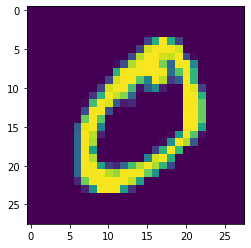

Label: 4


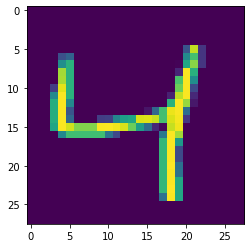

In [3]:
plt.imshow(imTrain[1])
print('Label:', labTrain[1])
plt.show()
plt.imshow(imTrain[2])
print('Label:', labTrain[2])

### Model Architecture

Let us now build a model which can classify these images as the correct digit. We will train it on the training set and test it on the test set.

First, instantiate the model. Because this is a simple task with only one type of input (image data) and one type of output (a number from 0-9), the Sequential model type will work well. This is a structure with no branching paths between layers in the model.

In [4]:
model = models.Sequential()

Next, let us add a densely connected or Dense type layer. Some parameters of the layer:

* 512 is the output shape, meaning that this layer will provide 512 learned features to the next layer.
* The activation function, known as ReLU or Rectified Linear Unit, will help prevent linear limitations in the features that can be learned. Generally, activation functions format data in a way that is useful.
* The input shape is a vector of length 28\*28, or 784. This is the number of pixels in the MNIST images, so all pixels will be delivered to this layer. Note that the input must be flattened first.

In [5]:
model.add(layers.Dense(512, activation='relu', input_shape=(28*28,)))

For a simple task, one additional layer should be sufficient to process the learned features and convert the information to a useful output—a set of ten probabilities representing the likelihood that the image is a particular digit.

* The output shape is 10, for the 10 probabilities (0-9).
* The softmax activation function will format the data into useful probabilities, on the range (0.0, 1.0).
* The input shape does not need to be specified. It is implied to be the same as the output shape of the previous layer.

In [6]:
model.add(layers.Dense(10, activation='softmax'))

Last, we must compile these layers into a proper model.

* Between steps in the training process, loss functions determine how inaccurate the model is so that it can self-correct. Crossentropy is a type of loss function which measures the difference between the probability distribution shown by the model and the correct distribution shown by the labels set. Because we are working with 10 categories of images, we must use the categorical type.
* The optimizer function specifies how the model self-corrects given the loss. RMSprop is a fast and useful optimizer.
* Metrics defines what it means to be incorrect for the model. In this case, with distinct and totally separate categories, accuracy of categorization is key.

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Pre-Processing

Above, it was noted that the MNIST data must be flattened before use. For simplicity, we should also normalize the pixel values to the range of (0.0, 1.0) instead of the current grayscale (0, 255). Let us do this now.

In [8]:
imTrain = imTrain.reshape((60000, 28*28))
imTrain = imTrain.astype('float32') / 255 # float32 is a non-integer data type
imTest = imTest.reshape((10000, 28*28))
imTest = imTest.astype('float32') / 255

Somewhat less intuitive is the processing of the labels.

When working with categorical data, the labels must be represented in a way that meshes well with how the neural net interprets the information. You may think that labelling each category 1, 2, 3, etc., should be sufficient, but this will sometimes result in an interesting problem—the neural net thinks that the ordering of the categories is meaningful, and may output results as if category 1 comes before category 2.

For instance, before the softmax activation function is used to report probabilities for each of the 10 digit categories, the model may internally recognize patterns as if the categories are an axis upon which data may lie. If it sees equal likelihood that an image is a 5 or a 7, it may mistakenly output the average, which would be 6. This is not desirable behavior in this case!

One way of handling this problem is known as 'one-hot encoding,' which looks like this:

In [9]:
print(labTrain[1])

0


In [10]:
labTrain = to_categorical(labTrain)
labTest = to_categorical(labTest)
print(labTrain[1])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Instead of listing a '0' digit as just that, one-hot encoding would initialize an array of length 10 (for 10 categories) which is all zeroes except for the correct category. This allows the model to completely separate each category in terms of the data structure, preventing mishaps like described above.

### Training and Testing

Now that the model and datasets are structured correctly, let us train the model.

* When training, the model will self-correct regularly via the loss and optimizer functions. To make sure this happens frequently enough, large datasets should be split into smaller batches; the model will then update after each batch. Here, the batch size is 128, meaning 128 images per batch.
* Epochs are successive iterations over the full dataset (all batches). With each epoch, the model self-corrects based on all data. We specify the training should progress over 5 epochs.

In [11]:
model.fit(imTrain, labTrain, batch_size=128, epochs=5)

Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.2562 - accuracy: 0.9261
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1035 - accuracy: 0.9689
Epoch 3/5
469/469 [==============================] - 3s 7ms/step - loss: 0.0679 - accuracy: 0.9799
Epoch 4/5
469/469 [==============================] - 3s 7ms/step - loss: 0.0494 - accuracy: 0.9853
Epoch 5/5
469/469 [==============================] - 3s 7ms/step - loss: 0.0364 - accuracy: 0.9891


On the training set, the model performs with approximately 98.9% accuracy. Now let us try the test set:

In [13]:
model.evaluate(imTest, labTest)[1]

313/313 [==============================] - 0s 1ms/step - loss: 0.0619 - accuracy: 0.9807


0.9807000160217285

On the test set, the model shows only 98.1% accuracy. This is still fairly good, but is worse than with the training set. That is evidence there may be 'overfitting' in the model, where false patterns in the training data were learned by accident.

### Validation Testing

One method of reducing overfitting (or at least checking for it during training) is by validating the model on a new test group between batches and epochs. The data used should not be the same data used for testing, to ensure there is no contamination.

First, let us try validating with a distinct 'validation' dataset which is used for neither testing nor training. This will be sliced out of the training set.

In [46]:
(imTrain, labTrain), (imTest, labTest) = mnist.load_data()
imVal = imTrain[-10000:]
labVal = labTrain[-10000:]
imTrain = imTrain[:-10000]
labTrain = labTrain[:-10000]
print(imVal.shape)
print(labVal.shape)
print(imTrain.shape)
print(labTrain.shape)

(10000, 28, 28)
(10000,)
(50000, 28, 28)
(50000,)


Then, preprocessing:

In [47]:
imTrain = imTrain.reshape((50000, 28*28))
imTrain = imTrain.astype('float32') / 255

imVal = imVal.reshape((10000, 28*28))
imVal = imVal.astype('float32') / 255

imTest = imTest.reshape((10000, 28*28))
imTest = imTest.astype('float32') / 255

labTrain = to_categorical(labTrain)
labVal = to_categorical(labVal)
labTest = to_categorical(labTest)

We must rebuild the model:

In [48]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28*28,)))
model.add(layers.Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

The validation data can be simply passed into the 'fit' function:

In [55]:
trainInfo = model.fit(imTrain, labTrain,
                      batch_size=128,
                      epochs=10,
                      validation_data=(imVal, labVal))

Epoch 1/10
  7/391 [..............................] - ETA: 6s - loss: 0.0330 - accuracy: 0.9900

C:\Users\silve\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


391/391 [==============================] - 7s 19ms/step - loss: 0.0301 - accuracy: 0.9914 - val_loss: 0.0730 - val_accuracy: 0.9788
Epoch 2/10
391/391 [==============================] - 7s 19ms/step - loss: 0.0231 - accuracy: 0.9933 - val_loss: 0.0763 - val_accuracy: 0.9805
Epoch 3/10
391/391 [==============================] - 7s 19ms/step - loss: 0.0173 - accuracy: 0.9949 - val_loss: 0.0776 - val_accuracy: 0.9777
Epoch 4/10
391/391 [==============================] - 7s 19ms/step - loss: 0.0134 - accuracy: 0.9963 - val_loss: 0.0846 - val_accuracy: 0.9790
Epoch 5/10
391/391 [==============================] - 7s 18ms/step - loss: 0.0100 - accuracy: 0.9973 - val_loss: 0.0755 - val_accuracy: 0.9803
Epoch 6/10
391/391 [==============================] - 7s 18ms/step - loss: 0.0079 - accuracy: 0.9977 - val_loss: 0.0850 - val_accuracy: 0.9813
Epoch 7/10
391/391 [==============================] - 7s 19ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.0804 - val_accuracy: 0.9832
Epoch 8/10

The 'fit' function returns some information which we saved as trainInfo. This can be visualized to better understand what is happening over training.

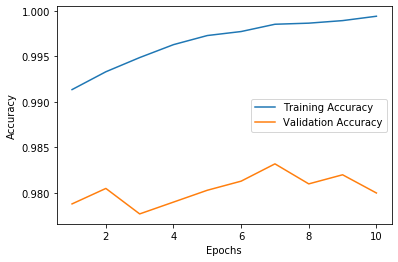

In [67]:
# Define a function for ease of use later
def plotAccuracy(trainInfo):
    # Define information
    accuracy = trainInfo.history['accuracy']
    valAccuracy = trainInfo.history['val_accuracy']
    epochs = range(1, len(accuracy) + 1)

    # Plot
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, valAccuracy, label='Validation Accuracy')

    # Format plot
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
plotAccuracy(trainInfo)

You can see that after 7 epochs, the validation accuracy begins to drop. This suggests that overfitting becomes more prominent after that point, so the model should not be allowed to progress.

Note that it is also possible to overfit to the validation dataset, if it is used too many times over.

In [57]:
model.evaluate(imTest, labTest)[1]

 28/313 [=>............................] - ETA: 1s - loss: 0.0892 - accuracy: 0.9833

C:\Users\silve\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


313/313 [==============================] - 1s 4ms/step - loss: 0.0961 - accuracy: 0.9799


0.9799000024795532

By doubling the number of epochs, it so happens that the model became *less accurate* on the test set. This is the danger of overfitting.

## Convolutional Neural Net

Now let us try a different type of neural net which is better-designed for images: convnets, or convolutional neural nets.

This type of neural net incorporates spatial data into the model by using a 'kernel,' a function which is mapped over each portion of the image. The benefit of this technique is minimizing information loss regarding the positions of different features of an image. By using different kernels, it is possible to specifically detect features like edges and color regions.

### Model Architecture

For this model, we will also use a Sequential form as there is still only one input and one output.

In [94]:
model = models.Sequential()

This time, instead of beginning with a Dense layer, we will use a Conv2D layer, or 2D convolutional layer.

* 32 is the number of filters (kernels) which will be passed over the images
* Each filter will be 3x3 pixels in size
* The ReLU activation function is used as before
* Previously, the input shape was a flat 784 pixels. However, because the goal in this case is to preserve the positions and spatial connections of individual pixels, we are instead passing the images in as 28x28 2D pictures. The 1 in this case refers to channels, the third dimension in image data. Because we are working in B&W, there is only one channel.
* When working with kernels, there are several approaches to handling the border of an image. By default, the picture will shrink by a small amount each time. This is not always a problem.

In [95]:
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))

With regards to shrinking the image, the MaxPooling2D layer type will in fact do this intentionally. This is a type of *downsampling*, where feature density is reduced to allow the model to learn patterns of different sizes as well as reduce the size and complexity of the final model (to prevent overfitting and excessive computational time).

Max pooling specifically will examine the image in specified kernel regions (here it is 2x2), then return only the maximum value within that region. As a result, only the maximum within each area is returned and the image shrinks.

In [96]:
model.add(layers.MaxPooling2D((2,2)))

Let us repeat this with a higher number of filters. With each layer, different features will be learned, thanks to the downsampling and feature 'memory' between layers.

In [97]:
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

To report the results of the model, it will need some way of formatting its outputs to be useful. It is convenient to use a method similar to that used earlier, where a Dense softmax layer returns a list of 10 probabilities. In order to use this type of layer, the three-dimensional image information must be flattened.

In [98]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Then, we can compile it as before.

In [99]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Pre-Processing

Once again, we must make sure the image data is in a useful form to be passed into the model. In this case, it must be in the form 28x28x1.

In [100]:
(imTrain, labTrain), (imTest, labTest) = mnist.load_data()
imTrain = imTrain.reshape((60000, 28, 28, 1))
imTrain = imTrain.astype('float32') / 255 # float32 is a non-integer data type
imTest = imTest.reshape((10000, 28, 28, 1))
imTest = imTest.astype('float32') / 255

The labels must be converted to one-hot encoding.

In [101]:
labTrain = to_categorical(labTrain)
labTest = to_categorical(labTest)

Then, we can remove a subset of the training data to be used for validation.

In [102]:
imVal = imTrain[-10000:]
labVal = labTrain[-10000:]
imTrain = imTrain[:-10000]
labTrain = labTrain[:-10000]

### Training and Results

In [109]:
trainInfo = model.fit(imTrain, labTrain, epochs=10, batch_size=128, validation_data=(imVal,labVal))

Epoch 1/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0169 - accuracy: 0.9947 - val_loss: 0.0389 - val_accuracy: 0.9890
Epoch 2/10
391/391 [==============================] - 39s 99ms/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 0.0390 - val_accuracy: 0.9890
Epoch 3/10
391/391 [==============================] - 39s 99ms/step - loss: 0.0104 - accuracy: 0.9968 - val_loss: 0.0489 - val_accuracy: 0.9882
Epoch 4/10
391/391 [==============================] - 38s 98ms/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0486 - val_accuracy: 0.9895
Epoch 5/10
391/391 [==============================] - 39s 99ms/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.0540 - val_accuracy: 0.9889
Epoch 6/10
391/391 [==============================] - 39s 99ms/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.0457 - val_accuracy: 0.9902
Epoch 7/10
391/391 [==============================] - 39s 100ms/step - loss: 0.0057 - accuracy: 0.9979 - val_loss: 0.0486 - val_accuracy

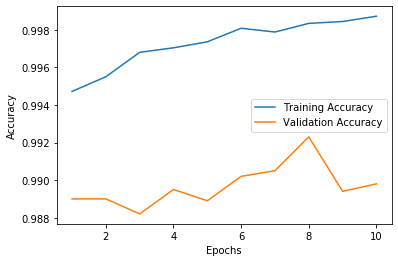

In [110]:
plotAccuracy(trainInfo)

According to the validation accuracy graph, it seems that the model should be run for no more than 8 epochs. Let us check the test accuracy:

In [111]:
model.evaluate(imTest, labTest)[1]

 11/313 [>.............................] - ETA: 3s - loss: 0.0045 - accuracy: 0.9972

C:\Users\silve\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


313/313 [==============================] - 3s 11ms/step - loss: 0.0441 - accuracy: 0.9919


0.9919000267982483

It seems the test accuracy is comparable to the validation accuracy, at approximately 99.2%. That is very good! Also note that this is significantly higher than when using only Dense layers—it would seem that spatial data is important to the task, if not the only necessary element.

### Changing the Kernel

In the previous case, we used a 3x3 pixel kernel to convolute over the image data. What happens if we use something much larger—say, a 5x5 kernel?

In [113]:
model = models.Sequential()

One issue which is likely to cause problems is the issue of image borders. Previously, we left this at the default option, which only accepts instances where the kernel is completely within the bounds of the image. However, as the kernel grows, this will result in fewer and fewer accepted instances. Therefore, let us use a different option to prevent this.

The padding parameter allows us to specify edge behavior. Here we use the 'same' option, which denotes that the image size should not shrink as a result of the convolution (it will still shrink with max pooling). This occurs via adding blank 'padding' to the image borders, which allows the kernel to process these sections.

In [114]:
model.add(layers.Conv2D(32, (5,5),
                        activation='relu',
                        input_shape=(28,28,1),
                        padding='same'))

In [115]:
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (5,5), activation='relu', padding='same'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [116]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [117]:
trainInfo = model.fit(imTrain, labTrain, epochs=10, batch_size=128, validation_data=(imVal,labVal))

Epoch 1/10
391/391 [==============================] - 107s 275ms/step - loss: 0.1994 - accuracy: 0.9357 - val_loss: 0.0488 - val_accuracy: 0.9864
Epoch 2/10
391/391 [==============================] - 117s 299ms/step - loss: 0.0436 - accuracy: 0.9860 - val_loss: 0.0413 - val_accuracy: 0.9882
Epoch 3/10
391/391 [==============================] - 113s 288ms/step - loss: 0.0283 - accuracy: 0.9914 - val_loss: 0.0425 - val_accuracy: 0.9895
Epoch 4/10
391/391 [==============================] - 106s 270ms/step - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.0333 - val_accuracy: 0.9911
Epoch 5/10
391/391 [==============================] - 105s 270ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.0372 - val_accuracy: 0.9889
Epoch 6/10
391/391 [==============================] - 107s 274ms/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 0.0331 - val_accuracy: 0.9920
Epoch 7/10
391/391 [==============================] - 106s 271ms/step - loss: 0.0078 - accuracy: 0.9973 - val_loss: 0.0285 -

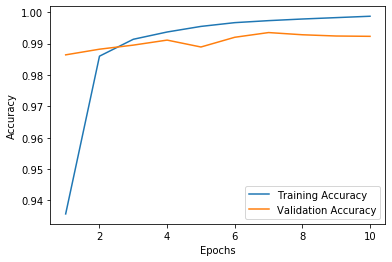

In [118]:
plotAccuracy(trainInfo)

It is interesting here that the validation accuracy is initially higher than the training accuracy. This may be due to random chance, where the validation set happened to be prototypical of the training set as a whole. There are alternate methods for producing a validation set, such as rotating or randomizing which portion of the training set is used between epochs, which may produce more natural results.

In [119]:
model.evaluate(imTest, labTest)[1]

  4/313 [..............................] - ETA: 5s - loss: 0.0261 - accuracy: 0.9922    

C:\Users\silve\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


313/313 [==============================] - 7s 23ms/step - loss: 0.0446 - accuracy: 0.9924


0.9923999905586243

It appears that kernel size did not have a significant impact on the testing accuracy in this case, possibly due to the padding method used.

## Reusability

Training a model on sufficient data can be time-consuming and resource-intensive. Therefore, it is often preferable to be able to reuse a previously trained model 